In [1]:
import os, sys
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 
sys.path.insert(0, parentdir) 
sys.path.insert(0, currentdir + "\Code") 

In [2]:
import math
import pickle
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib import rc
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
import scipy
from scipy.integrate import odeint, DOP853, solve_ivp
from scipy.stats import special_ortho_group
from itertools import chain, combinations, permutations
import seaborn as sns

from ring_functions_noorman import *

"""cmap = 'gray'
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)"""

"cmap = 'gray'\nrc('font', **{'family': 'serif', 'serif': ['Computer Modern']})\nrc('text', usetex=True)"

In [125]:
# symmetric cosine weight matrix W sym jk = JI + JE cos(theta_j - theta_K)
# where JE and JI respectively control the strength of the tuned and untuned components of recurrent connectivity between neurons with preferred headings theta_j and theta_k.

# For a network of size N , there are N 3 such “optimal” values of local excitation J*E

# The parameters (JI, JE) can be set such that this system will generate a population profile that qualitatively looks like a discretely sampled “bump” of activity.
# (JI, JE) are within the subset  \Omega = \OmegaJI\times\OmegaJE \subset (−1, 1) \times (2,1)

def get_corners(N, m):
    #works for even N
    corners = []
    corner_0 = np.array([m]*N)
    corner_0[int(N/2):] *= -1
    corner_0[int(N/2)-int(N/4):int(N/2)] = 0
    corner_0[N-int(N/4):] = 0
    for support_j in range(N):
        corners.append(np.roll(corner_0, support_j))
    corners = np.array(corners)
    return corners

def get_bumps_along_oneside_ring(N, m, corners, step_size=0.1):
    x = np.arange(0, m+step_size, step_size)
    n_xs = x.shape[0]
    bumps = np.zeros((N, n_xs))
    for i, x_i in enumerate(x):
        for j in range(N):
            bumps[j,i] = np.interp(x_i, [0,m], [corners[0][j],corners[1][j]])
    return bumps

def get_all_bumps(N, bumps):
    all_bumps = []
    for support_j in range(N):
        for bump_i in range(bumps.shape[1]):
            all_bumps.append(np.roll(bumps[:,bump_i], support_j))
    all_bumps = np.array(all_bumps)
    return all_bumps

def get_all_bumps_2darray(N, bumps):
    all_bumps = np.zeros((N,bumps.shape[1],N))
    for support_j in range(N):
        for bump_i in range(bumps.shape[1]):
            all_bumps[support_j,bump_i] = np.roll(bumps[:,bump_i], support_j)
    return all_bumps

def get_noorman_symmetric_weights(N, J_I = 1, J_E = 1):
    # W sym jk = JI + JE cos(theta_j - theta_K)
    x = np.arange(0,N,1)
    row = J_I + J_E*np.cos(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W


# W asym jk =sin(theta_j - theta_k)
def get_noorman_asymmetric_weights(N):
    # W asym jk =sin(theta_j - theta_k)
    x = np.arange(0,N,1)
    row = np.sin(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W

def noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N):
    """Differential equation of head direction network in Noorman et al., 2022. 
    tau: integration constant
    transfer_function: each neuron transforms its inputs via a nonlinear transfer function
    W_sym, W_asym: symmetric and asymmetric weight matrices
    v_in: input
    c_ff: a constant feedforward input to all neurons in the network
    N: number of neurons in the network
    """

    return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff)/tau

def noorman_ode_with_noise(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,noises):
    """Differential equation of head direction network in Noorman et al., 2022. 
    tau: integration constant
    transfer_function: each neuron transforms its inputs via a nonlinear transfer function
    W_sym, W_asym: symmetric and asymmetric weight matrices
    v_in: input
    c_ff: a constant feedforward input to all neurons in the network
    N: number of neurons in the network
    """
    if noises is not None:
        index = int(min(max(round(t), 0), len(noises)-1))
        noises_at_t = noises[index]  # Now this is guaranteed to be valid
        return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff + noises_at_t)/tau
    else:
        return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff)/tau

#Bump perturbations
def noorman_ode_pert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,center,rotation_mat,amplitude,b):
    """
    create ODE for Noorman ring attractor with a local bump perturbation
    center,rotation_mat,amplitude,b are set
    """
    vector_bump = bump_perturbation(x, center, rotation_mat, amplitude, b)
    noor = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    return noor + vector_bump

def noorman_ode_Npert(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,Nbumps):
    """
    create ODE for Noorman ring attractor with Nbumps local bump perturbations
    for each bump: center,rotation_mat,amplitude,b are random
    """
    noorode = noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N)
    for bi in range(Nbumps):
        bump_i = np.random.randint(bumps.shape[0]) 
        roll_j = np.random.randint(N)
        center = np.roll(bumps[:,bump_i], roll_j).copy()
        rotation_mat = special_ortho_group.rvs(N)
        amplitude = np.random.rand()
        b = np.random.rand()
        noorode += bump_perturbation(x, center, rotation_mat, amplitude, b)

    return noorode

# Fixed points and their stabilities
def noorman_jacobian(x, W_sym):
    N = W_sym.shape[0]
    
    r = np.where(x>0)
    W_sub = np.zeros((N,N))
    W_sub[:,r] = W_sym[:,r]
    J = -np.eye(N)
    J += W_sub/N
    return J

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def noorman_fixed_points(W_sym, c_ff):
    """
    Takes as argument all the parameters of the recurrent part of the model (W_sym, c_ff)
    \dot x = -x + 1/N W_sym ReLU(x) + c_ff = 0
    """
    fixed_point_list = []

    N = W_sym.shape[0]
    subsets = powerset(range(N))
    for support in subsets:
        if support == ():
            continue
        r = np.array(support)
        
        W_sub = np.zeros((N,N))
        W_sub[:,r] = W_sym[:,r]
        A = W_sub/N - np.eye(N)
        fixed_point = -np.dot(np.linalg.inv(A), np.ones(N)*c_ff)
        
        #check true fixed point
        negativity_condition = True
        # print(r, [item for item in range(N) if item not in r])
        for i in r:
            if fixed_point[i] <= 0:
                negativity_condition = False
        for i in [item for item in range(N) if item not in r]:
            if fixed_point[i] >= 0:
                negativity_condition = False
        
        if negativity_condition:
            fixed_point_list.append(fixed_point)
        
    fixed_point_array = np.array(fixed_point_list)
    return fixed_point_array




def bump_perturbation(x, center, rotation_mat, amplitude, b=1):
    """
    Perturbation is composed of parallel vector field 
    with the location given by center, 
    the norm of the vectors determined by a bump function
    and the orientation given by theta
    
    x.shape = (Numberofpoints,N)
    rotation_mat: orientation of perturbation
    implemented for N-dimensional systems
    """
    N = x.shape[0]
    vector_bump = np.zeros(N)
    vector_bump[0] = 1.
    rotation_mat = special_ortho_group.rvs(N)
    vector_bump = np.dot(vector_bump, rotation_mat)
    vector_bump = np.multiply(vector_bump, bump_function(x, center=center, amplitude=amplitude, b=b))
    
    return vector_bump

# we will take phi(·) to be threshold linear

def v_in(t):
    return 0

def ReLU(x):
    return np.where(x<0,0,x)



# Get trajectories with state noise

In [127]:
def get_network(N,J_E,J_I):
    W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
    W_asym = get_noorman_asymmetric_weights(N)
    c_ff = 1.

    maxT = 100
    n_timesteps = 100
    t = np.linspace(0, maxT, n_timesteps)

    y0 = np.random.uniform(0,1,N)

    sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)

    m = np.max(sol.sol(t)) # m #round? what should the maximum be according to the paper?
    corners = get_corners(N, m)
    bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.05)
    step_size = .1
    x = np.arange(0, m+step_size, step_size)
    all_bumps = get_all_bumps(N, bumps)
    return corners, all_bumps, W_sym, W_asym, t

def get_network_with_automatic_corners(N,J_E,J_I,t):
    W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
    W_asym = get_noorman_asymmetric_weights(N)
    c_ff = 1.

    y0 = np.random.uniform(0,1,N)

    sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,t[-1]], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)

    corners=[]
    for support_j in range(N):
        corners.append(np.roll(sol.sol(t)[:,-1], support_j))
    corners = np.array(corners)

    m = np.max(sol.sol(t)) # m #round? what should the maximum be according to the paper?
    bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=m/3)
    all_bumps = get_all_bumps(N, bumps)

    return corners, all_bumps, W_sym, W_asym

def get_perturbation(seed,norm,corners_max,N,t):
    np.random.seed(seed)
    eps = np.random.uniform(-1,1,(len(t)+1,N))
    eps /= np.linalg.norm(eps)
    eps *= norm * corners_max / 100 # define norm as percentage of maximum activity
    return eps

def get_trajectories(all_bumps,W_sym, W_asym, external_t, N, noises):

    trajectories = np.zeros((all_bumps.shape[0], len(external_t), N))
    
    for i in range(all_bumps.shape[0]):
        sol = solve_ivp(noorman_ode_with_noise, y0=all_bumps[i,:],  t_span=[0,external_t[-1]], t_eval=external_t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N, noises]),dense_output=True)
        trajectories[i] = sol.sol(external_t).T
    return trajectories

In [128]:
import numpy as np
from scipy.optimize import curve_fit

def von_mises(x, A, kappa, mu, C):
    """Von Mises function (circular Gaussian-like)"""
    return A * np.exp(kappa * (np.cos(x - mu) - 1)) + C

import numpy as np

def get_angle_from_bump(activity, sigma_smooth=3):
    """
    Compute the center of mass (CoM) and smooth peak location for a bump in a ring attractor.

    Parameters:
        activity (1D numpy array): Activity values along the ring.
        sigma_smooth (float): Smoothing width for peak estimation (default: 3).

    Returns:
        com_angle (float): Center of mass in radians.
        peak_smooth (float): Smoothed peak location in radians.
    """
    N = len(activity)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)  # Circular angles

    # Compute circular center of mass (CoM)
    x_com = np.sum(np.cos(angles) * activity)
    y_com = np.sum(np.sin(angles) * activity)
    com_angle = np.arctan2(y_com, x_com)

    # Find initial peak location
    peak_idx = np.argmax(activity)
    
    # Define Gaussian weights centered on peak
    idxs = np.arange(N)
    distances = np.minimum(np.abs(idxs - peak_idx), N - np.abs(idxs - peak_idx))  # Circular distance
    weights = np.exp(-0.5 * (distances / sigma_smooth) ** 2)  # Gaussian weights
    
    # Compute weighted average of angles
    peak_smooth = np.arctan2(
        np.sum(weights * np.sin(angles) * activity),
        np.sum(weights * np.cos(angles) * activity)
    )

    return com_angle, peak_smooth

def get_angle_diffs(trajectories):
    centre_of_mass_diffs, peak_location_diffs = [], []
    for trajectory in trajectories:
        initial_state = trajectory[0]
        final_state = trajectory[-1]
        centre_of_mass_initial, peak_location_initial = get_angle_from_bump(initial_state)
        centre_of_mass_final, peak_location_final = get_angle_from_bump(final_state)

        centre_of_mass_diff = np.abs(centre_of_mass_final-centre_of_mass_initial)
        centre_of_mass_diff = np.min([centre_of_mass_diff, 2*np.pi-centre_of_mass_diff])
        centre_of_mass_diffs.append(np.degrees(centre_of_mass_diff))

        peak_location_diff = np.abs(peak_location_final-peak_location_initial)
        peak_location_diff = np.min([peak_location_diff, 2*np.pi-peak_location_diff])
        peak_location_diffs.append(np.degrees(peak_location_diff))

    return centre_of_mass_diffs, peak_location_diffs

In [129]:
def plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N, W_sym,intermediate_timestep):

    pca = sklearn.decomposition.PCA(n_components=2)

    corners_proj = pca.fit_transform(corners)

    if fixed_points is not None:
        fixed_points_proj = pca.transform(fixed_points.reshape(-1,N))

    points_on_manifold_proj = pca.transform(inv_man)

    trajectory_states_proj = pca.transform(trajectories[trajectory_index])
    final_trajectory_state_proj = pca.transform(trajectories[trajectory_index,-1].reshape(-1,N))
    initial_trajectory_state_proj = pca.transform(trajectories[trajectory_index,0].reshape(-1,N))
    intermediate_trajectory_state_proj = pca.transform(trajectories[trajectory_index,intermediate_timestep].reshape(-1,N))

    for i in range(points_on_manifold_proj.shape[0]):
        plt.plot(points_on_manifold_proj[i,0], points_on_manifold_proj[i,1], '.', color='m', label="Analytical", zorder=99, alpha=0.1, markersize= 5)

    for i in range(N):
        plt.plot([corners_proj[i-1,0], corners_proj[i,0]],
                [corners_proj[i-1,1], corners_proj[i,1]],
                'k', label="Original attractor", zorder=0, alpha=0.1, linewidth=10, 
                solid_capstyle='round')

    if fixed_points is not None:
        for i in range(fixed_points.shape[0]):
            eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_points[i], W_sym))
            if np.all(np.real(eigenvalues)<0):
                plt.plot(fixed_points_proj[i,0], fixed_points_proj[i,1], '*', color="darkblue", label="Stable", zorder=10, alpha=1., markersize=15) # final states of the trajectories 
            else:
                plt.plot(fixed_points_proj[i,0], fixed_points_proj[i,1], '*', color="darkorange", label="Stable", zorder=10, alpha=1., markersize=15) # final states of the trajectories 
            
    #plt.plot(fixed_point_proj[:,0], fixed_point_proj[:,1], '^b', label="Stable", zorder=10, alpha=1., markersize=20) # final states of the trajectories 
    
    plt.plot(trajectory_states_proj[:,0], trajectory_states_proj[:,1], '.k', label="Stable", zorder=10, alpha=1., markersize=10) # final states of the trajectories 
    plt.plot(initial_trajectory_state_proj[:,0], initial_trajectory_state_proj[:,1], '.g', label="Stable", zorder=10, alpha=1., markersize=20) # final states of the trajectories 
    plt.plot(intermediate_trajectory_state_proj[:,0], intermediate_trajectory_state_proj[:,1], '.m', label="Stable", zorder=10, alpha=1., markersize=20) # final states of the trajectories 
    plt.plot(final_trajectory_state_proj[:,0], final_trajectory_state_proj[:,1], '.r', label="Stable", zorder=10, alpha=1., markersize=20) # final states of the trajectories 


In [130]:
def get_speed_and_acceleration(trajectory):
    speeds = []
    accelerations = []
    for t in range(trajectory.shape[0]-1):
        speed = np.linalg.norm(trajectory[t+1, :]-trajectory[t, :])
        speeds.append(speed)
    for t in range(trajectory.shape[0]-2):
        acceleration = np.abs(speeds[t+1]-speeds[t])
        accelerations.append(acceleration)
    speeds = np.array(speeds)
    accelerations = np.array(accelerations)
    return speeds, accelerations

def get_speed_and_acceleration_batch(trajectories):
    all_speeds = []
    all_accs = []
    for trajectory in trajectories:
        speeds, accelerations = get_speed_and_acceleration(trajectory)
        all_speeds.append(speeds)
        all_accs.append(accelerations)
    return np.array(all_speeds), np.array(all_accs)

def detect_slow_manifold(trajectories, subsample=10, tol=0):
    # for each trajectory, gets the index at which the speed starts to be low enough & 
    # from those points extract all onwards timesteps, with steps of 10 timesteps 
    all_speeds, all_accs = get_speed_and_acceleration_batch(trajectories)
    idx = np.argmax(all_speeds - all_speeds[:,-1][:,np.newaxis] < tol,axis=1)
    inv_man = np.empty((0,trajectories.shape[-1]))
    for i,index in enumerate(idx):
        inv_man = np.vstack([inv_man, trajectories[i,index::subsample,:]])
    return inv_man

def detect_slow_manifold_keep_time(trajectories, tol=0):
    all_speeds, all_accs = get_speed_and_acceleration_batch(trajectories)
    idx = np.argmax(all_speeds - all_speeds[:,-1][:,np.newaxis] < tol,axis=1)
    s = all_speeds - all_speeds[:,-1][:,np.newaxis]
    inv_man = []#np.empty((0,trajectories.shape[-1]))
    for i,index in enumerate(idx):
        inv_man.append(trajectories[i,index:index+2,:])
    return np.array(inv_man)

### Find good (J_E,J_I) combinations

In [11]:
N=6 # only run for N=6 because for this task N doesn't make a difference, the weights only depend on J_E and J_I
activity_limits_exceeded = []
zero_fixed_points = []
large_time_constant_score = []
symmetric_matrix = []
valid_JE_JI_combinations = []
tau=1
transfer_function=ReLU

for J_E in np.arange(1,15,1)[:]:
    for J_I in np.arange(-1,-15,-1)[:]:
        corners, all_bumps, W_sym, W_asym, t = get_network_with_automatic_corners(N,J_E,J_I)
        if (corners.max() > 100) or (corners.min() < -100):
            activity_limits_exceeded.append((J_E,J_I))
        else:
            try:
                fixed_points = noorman_fixed_points(W_sym, c_ff)[:-1]
                n_fixed_points = len(fixed_points)
            except: # attractor is continuous
                symmetric_matrix.append((J_E,J_I))
                n_fixed_points = 0
            if n_fixed_points == 0:
                zero_fixed_points.append((J_E,J_I))
            else: # check rate of speed parallel / speed normal to manifold is small
                for fixed_point in fixed_points:
                    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym))
                    if np.all(np.real(eigenvalues)<0): # check whether stable point
                        sorted_eigenvalues = np.sort(np.abs(eigenvalues))
                        time_constant_score = sorted_eigenvalues[0] / sorted_eigenvalues[1]
                        if time_constant_score > 0.5:
                            large_time_constant_score.append((J_E,J_I))
                            break
        if (J_E,J_I) not in activity_limits_exceeded:
            valid_JE_JI_combinations.append((J_E,J_I))

# Get results for one (seed,norm) combination

12


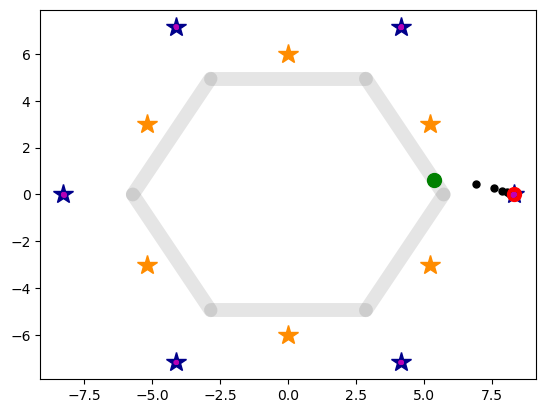

In [ ]:
N, J_E = 6, 5.8
seeds = [27, 0, 3, 13, 418, 1550]
seed=seeds[2]
#norms =  [1e-10, 1e-5, 1e-1, .5, 1, 1.1, 1.5, 2, 2.5, 3, 4, 5]
#norm=norms[-1]

c_ff, tau = 1, 1
transfer_function = ReLU
maxT = 100
n_timesteps = 100
t = np.linspace(0, maxT, n_timesteps)
corners, all_bumps, W_sym, W_asym, t = get_network(N,J_E)

corners_max = corners.max()
norms = [1e-10,1e-5,1e-2,1e-1,0.5,1]
norm = norms[0]
norm = norm * corners_max # define norm as percentage of maximum activity

trajectories = get_trajectories(all_bumps,W_sym, W_asym, t, maxT, seed, norm, N)
fixed_points = noorman_fixed_points(W_sym, c_ff)[:-1]
print(len(fixed_points))

inv_man = detect_slow_manifold(trajectories,tol=1e-2)
trajectory_index=50
plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N)

angle_diffs, peak_location_diffs = np.array(get_angle_diffs(trajectories))

# Get results for several combinations

#### Define parameters

In [9]:
valid_JE_JI = [(10,-6),(10,-7),(10,-8),(10,-9),(10,-10),(10,-11),(10,-12),(10,-13),(10,-14),
               (9,-5),(9,-6),(9,-7),(9,-8),(9,-9),(9,-10),(9,-11),(9,-12),(9,-13),(9,-14),
               (8,-5),(8,-6),(8,-7),(8,-8),(8,-9),(8,-10),(8,-11),(8,-12),(8,-13),(8,-14),
               (7,-4),(7,-5),(7,-6),(7,-7),(7,-8),(7,-9),(7,-10),(7,-11),(7,-12),(7,-13),(7,-14),
               (6,-3),(6,-4),(6,-5),(6,-6),(6,-7),(6,-8),(6,-9),(6,-10),(6,-11),(6,-12),(6,-13),(6,-14),
                (5,-2),(5,-3),(5,-4),(5,-5),(5,-6),(5,-7),(5,-8),(5,-9),(5,-10),(5,-11),(5,-12),(5,-13),(5,-14),
                (4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),(4,-7),(4,-8),(4,-9),(4,-10),(4,-11),(4,-12),(4,-13),(4,-14),
                (3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),(3,-7),(3,-8),(3,-9),(3,-10),(3,-11),(3,-12),(3,-13),(3,-14),
               ]

In [ ]:
tau, c_ff = 1, 1
transfer_function = ReLU
maxT = 20
n_timesteps = maxT
t = np.linspace(0,maxT,n_timesteps)
num_seeds = 10
np.random.seed(0)
seeds = np.random.randint(0, 2**15, size=num_seeds)
norms = [1,5,10,20,30,40,50,60,70,80,90,100]

#N_range = np.concatenate((np.arange(6,20,2), np.arange(20,84,4)))
N_range = np.arange(20,84,4)

##### Run simulations over all parameter combinations

In [ ]:
def get_results(N,J_E,J_I,seed,norm,t):

    corners, all_bumps, W_sym, W_asym = get_network_with_automatic_corners(N,J_E,J_I,t)
    corners_max = np.abs(corners).max()

    noises = get_perturbation(seed,norm,corners_max,N,t)

    trajectories = get_trajectories(all_bumps,W_sym, W_asym, t, N, noises) 

    # try:
    #     fixed_points = noorman_fixed_points(W_sym, c_ff)[:-1]
    # except:
    #     fixed_points = None

    # inv_man = detect_slow_manifold(trajectories,tol=1e-2)
    # trajectory_index=166
    # plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N,eps)

    angle_diffs, peak_location_diffs = np.array(get_angle_diffs(trajectories))

    return angle_diffs

for N in N_range:
    for combination in valid_JE_JI:
        J_E, J_I = combination[0], combination[1]
        results = {}
        for seed in seeds:
            for norm in norms:
                print(N,J_E,J_I,seed,norm)
                results[(N,J_E,J_I,seed,norm)] = get_results(N,J_E,J_I,seed,norm,t)
        with open("results//all_JE_JI//state_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "wb") as f:
            pickle.dump(results, f)
        del results

20 10 -6 2732 1
20 10 -6 2732 5
20 10 -6 2732 10
20 10 -6 2732 20
20 10 -6 2732 30
20 10 -6 2732 40
20 10 -6 2732 50
20 10 -6 2732 60
20 10 -6 2732 70
20 10 -6 2732 80
20 10 -6 2732 90
20 10 -6 2732 100
20 10 -6 10799 1
20 10 -6 10799 5
20 10 -6 10799 10
20 10 -6 10799 20
20 10 -6 10799 30
20 10 -6 10799 40
20 10 -6 10799 50
20 10 -6 10799 60
20 10 -6 10799 70
20 10 -6 10799 80
20 10 -6 10799 90
20 10 -6 10799 100
20 10 -6 9845 1
20 10 -6 9845 5
20 10 -6 9845 10
20 10 -6 9845 20
20 10 -6 9845 30
20 10 -6 9845 40
20 10 -6 9845 50
20 10 -6 9845 60
20 10 -6 9845 70
20 10 -6 9845 80
20 10 -6 9845 90
20 10 -6 9845 100
20 10 -6 19648 1
20 10 -6 19648 5
20 10 -6 19648 10
20 10 -6 19648 20
20 10 -6 19648 30
20 10 -6 19648 40
20 10 -6 19648 50
20 10 -6 19648 60
20 10 -6 19648 70
20 10 -6 19648 80
20 10 -6 19648 90
20 10 -6 19648 100
20 10 -6 13123 1
20 10 -6 13123 5
20 10 -6 13123 10
20 10 -6 13123 20
20 10 -6 13123 30
20 10 -6 13123 40
20 10 -6 13123 50
20 10 -6 13123 60
20 10 -6 13123 70
20 1

# Analyze results

### Single combination: maximum angular error

In [60]:
N, J_E, J_I, seed, norm = 20, 8, -5, seeds[0], norms[2]
with open("results//all_JE_JI//state_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
        results = pickle.load(f)
angle_errors = results[(N,J_E,J_I,seed,norm)][0]

plt.plot(angle_errors)
plt.title('Angular errors for (N, J_E, seed, norm)=({},{},{},{})'.format(N,J_E,seed,norm))
plt.xlabel('Trajectory id')
plt.ylabel('Angular error (degrees)')

### Multiple (N,J_E,J_I,seed,norm) combinations: maximum angular error

In [58]:
def extract_angle_errors(N_range,valid_JE_JI,filter_bool,filter_idx,filter_value):
    all_angle_errors = {}
    counts = {}
    for N_idx, N in enumerate(N_range):
        for combination in valid_JE_JI:
            J_E, J_I = combination[0], combination[1]

            with open("results//all_JE_JI//state_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
                    results = pickle.load(f)
            for seed in seeds:
                for norm in norms:

                    # replace one of the parameters with the one from the fn arguments
                    param_comb = [N,J_E,J_I,seed,norm]
                    if filter_bool:
                        param_comb[filter_idx] = filter_value
                    angle_errors = results[tuple(param_comb)][0]
                    
                    if N in list(all_angle_errors.keys()):
                        all_angle_errors[N] = np.max((all_angle_errors[N], np.max(angle_errors)))
                    else:
                        all_angle_errors[N] = np.max(angle_errors)
                        
                    if N in list(counts.keys()):
                        counts[N] += 1
                    else:
                        counts[N] = 1
    return list(all_angle_errors.values()), list(counts.values())

#### Variation across norms

Text(0.5, 1.0, 'Max angular error for different state noise norm')

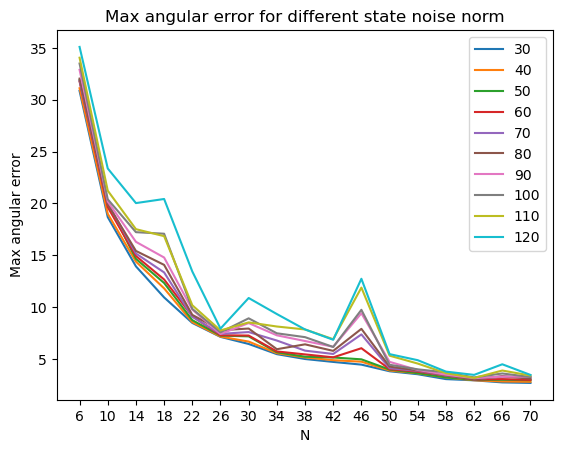

In [ ]:
filter_bool=True
filter_idx=-1
for norm in norms:
    angle_errors, counts = extract_angle_errors(N_range,valid_JE_JI,filter_bool,filter_idx,norm)
    plt.plot(angle_errors, label=f'{norm}')
plt.legend()
plt.xticks(np.arange(len(angle_errors)),N_range)
plt.title('Maximum angular errors for different state noise norms',fontsize=15)
plt.xlabel('N',fontsize=12)
plt.ylabel('Angular error',fontsize=12)

#### Variation across seeds

Text(0.5, 1.0, 'Max angular error for different state noise norm')

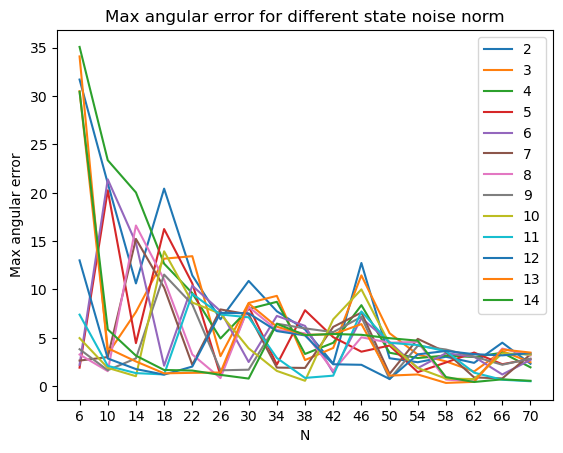

In [62]:
filter_bool=True
filter_idx=-2
for seed in seeds:
    angle_errors, counts = extract_angle_errors(N_range,valid_JE_JI,filter_bool,filter_idx,seed)
    plt.plot(angle_errors, label=f'{seed}')
plt.legend()
plt.xticks(np.arange(len(angle_errors)),N_range)
plt.title('Maximum angular errors for different state noise seeds',fontsize=15)
plt.xlabel('N',fontsize=12)
plt.ylabel('Angular error',fontsize=12)

#### Maximum angular errors per N

In [ ]:
filter_bool=False
filter_idx=-2
seed=seeds[0]

angle_errors, counts = extract_angle_errors(N_range,valid_JE_JI,filter_bool,filter_idx,seed)
plt.plot(angle_errors)
plt.legend()
plt.xticks(np.arange(len(angle_errors)),N_range)
plt.title('Maximum angular errors for all seeds & norms',fontsize=15)
plt.xlabel('N',fontsize=12)
plt.ylabel('Angular error',fontsize=12)

#### Trajectory visualization

In [ ]:
seed, norm = seeds[3], norms[-1]
N=6
J_E, J_I = 3, -1

corners, all_bumps, W_sym, W_asym = get_network_with_automatic_corners(N,J_E,J_I,t)
corners_max = np.abs(corners).max()

noises = get_perturbation(seed,norm,corners_max,N,t)

trajectories = get_trajectories(all_bumps,W_sym, W_asym, t, N, noises) 

fixed_points = noorman_fixed_points(W_sym, c_ff)[:-1]
#print(len(fixed_points))

inv_man = detect_slow_manifold(trajectories,tol=1e-2)
trajectory_index=3

plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N, W_sym,intermediate_timestep)
with open("results//all_JE_JI//state_noise//angle_errors_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
        results = pickle.load(f)
angle_error = results[N,J_E,J_I,seed,norm]
plt.title('Angular error: {} degrees'.format(round(angle_error)))

## Check saddle point crossing

#### Get all fixed points

In [ ]:
all_fixed_points = {}
for N in np.arange(6,20,4):
    # try all J_E in (2,6,0.1) but skip 4 because it leads to a singular matrix and fixed points cannot be calculated
    for J_E in np.arange(2,15):
        perc = 2*(J_E-4)/4
        J_I=-2.4 - perc*2.4 # increase or decrease inhibition to maintain attractor stability and activity values around the same maxima

        corners, all_bumps, W_sym, W_asym, t = get_network(N,J_E,J_I)

        try:
            fixed_points = noorman_fixed_points(W_sym, c_ff)[:-1]
        except:
            fixed_points = None
        all_fixed_points[(N,J_E)] = fixed_points

6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 14


#### Calculate index of closest fixed point throughout trajectory

In [ ]:
seeds = [27, 0, 3, 13, 418, 1550] 
norms = np.arange(30,130,10)

seed = seeds[0]
norm_idx = 1

for idx, key in enumerate(list(all_fixed_points.keys())[:]):
    if all_fixed_points[key] is not None:
        #print('\n',key)
        N, J_E = key[0], key[1]
        perc = 2*(J_E-4)/4
        J_I=-2.4 - perc*2.4
        
        corners, all_bumps, W_sym, W_asym, t = get_network(N,J_E,J_I)
        corners_max = corners.max()
        norm = norms[norm_idx]
        norm = norm * corners_max / 100 # define norm as percentage of maximum activity

        range_middle_interval = np.arange(round(all_bumps.shape[0]/N/2), round((N-1) * all_bumps.shape[0]/N + all_bumps.shape[0]/N/2), all_bumps.shape[0]/N).astype(int)
        trajectories = get_trajectories(all_bumps[range_middle_interval],W_sym, W_asym, t, maxT, seed, norm, N)

        fixed_points = all_fixed_points[key]
        stable_points = []
        for fixed_point in fixed_points[:-1]:
            eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym))
            if np.all(np.real(eigenvalues)<0):
                stable_points.append(fixed_point)
        stable_points = np.array(stable_points)
        if stable_points.shape[0] > 0:
            # with open("results//state_noise//angle_errors_{}_{}.pkl".format(N,J_E), "rb") as f:
            #     results = pickle.load(f)
            # for seed in seeds:
            #     for norm in norms:
            #         print(results[(N,J_E,seed,norm)].shape)

            diff = trajectories[:, :, np.newaxis, :] - stable_points[np.newaxis, np.newaxis, :, :]
            distances = np.linalg.norm(diff, axis=-1)
            closest_indices = np.argmin(distances, axis=2)
            all_timesteps_equal = np.all(closest_indices[:,10:] == closest_indices[:, 10:11], axis=1) # shape (starting_points,1)
            if np.any(all_timesteps_equal == False):
                first_index_false = np.where(~all_timesteps_equal)[0][0]
                unique, counts = np.unique(closest_indices[first_index_false], return_counts=True)
                frequent2rare_proportion = counts.max()/counts.min() # get a measure of how equally distributed the indices of the closest stable points are; low values are better
                print(idx,key,all_timesteps_equal,frequent2rare_proportion)
                break


3 (14, 9) [ True  True False False False  True  True  True  True False  True False
  True] 1.0408163265306123


In [578]:
diff.shape, distances.shape, closest_indices.shape, all_timesteps_equal.shape, np.any(all_timesteps_equal==False)

((13, 100, 14, 14), (13, 100, 14), (13, 100), (13,), True)

In [579]:
all_timesteps_equal, first_index_false, np.where(~all_timesteps_equal)[0][0]

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True]),
 9,
 9)

In [580]:
closest_indices[-4],closest_indices.shape

(array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 13, 13, 13, 13,
        13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]),
 (13, 100))

In [581]:

unique, counts = np.unique(closest_indices[-4], return_counts=True)
unique, counts, counts.max()/counts.min()



(array([12, 13]), array([12, 88]), 7.333333333333333)

In [ ]:
distances[2,closest_indices[2]].shape

(100, 100, 14)

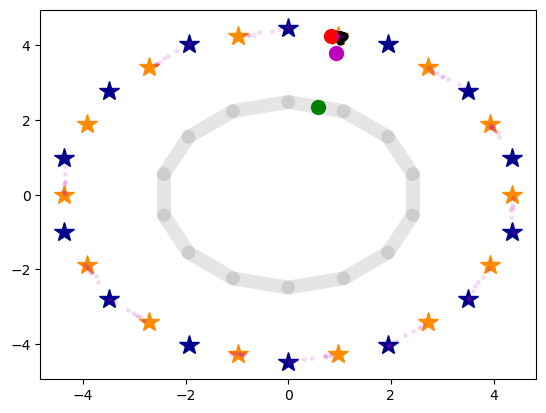

In [547]:
trajectory_index=2

inv_man = detect_slow_manifold(trajectories,tol=1e-2)

plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N, W_sym,intermediate_timestep)


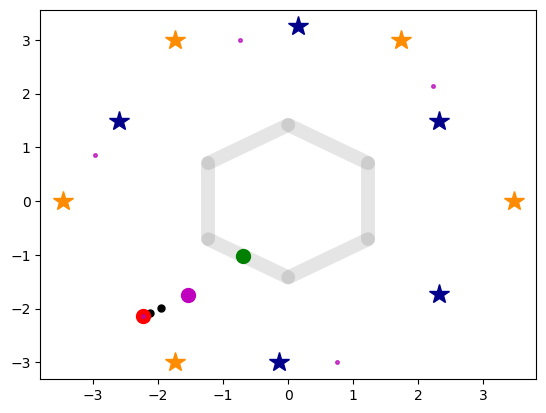

In [ ]:


perc = 2*(J_E-4)/4
J_I=-2.4 - perc*2.4

corners, all_bumps, W_sym, W_asym, t = get_network(N,J_E,J_I)
corners_max = corners.max()
norm = norm * corners_max / 100 # define norm as percentage of maximum activity
range_middle_interval = np.arange(round(all_bumps.shape[0]/N/2), round((N-1) * all_bumps.shape[0]/N + all_bumps.shape[0]/N/2), all_bumps.shape[0]/N).astype(int)

trajectories = get_trajectories(all_bumps[range_middle_interval],W_sym, W_asym, t, maxT, seed, norm, N)
fixed_points = noorman_fixed_points(W_sym, c_ff)[:-1]

stable_points = []
for fixed_point in fixed_points[:-1]:
    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym))
    if np.all(np.real(eigenvalues)<0):
        stable_points.append(fixed_point)
stable_points = np.array(stable_points)

#print(len(fixed_points))
#fixed_points = None

inv_man = detect_slow_manifold(trajectories,tol=1e-2)
trajectory_index=0
intermediate_timestep=1

plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N, W_sym,intermediate_timestep)


# Small border crossings from norm 40% onwards
N 10 J_E 3 norm idx 1 trajectory idx 0 is enough to skip saddle border
N 14 J_E 9 norm idx 1 trajectory idx 0 is enough to skip saddle border
N 10 J_E 3 norm idx 7 trajectory idx 0 is enough to skip saddle border
N 18 J_E 7 norm idx 5 trajectory idx 2 is enough to skip saddle border

# Large border crossings from norm 80% onwards
N 14 J_E 3 norm idx 5 trajectory idx 0 is enough to skip saddle border